# Classification avancée 
# A - Données non équilibrées
## 1 - Jeux de données déséquilibrés
La classification sur données déséquilibrées est un problème de classification ou l'échantillon d'apprentissage contient une forte disparité entre les classes à prédire.
Ce problème revient fréquemment dans les problèmes de classifications binaires, et notamment la détection d'anomalies.

Dans le cas de données comportant une classe fortement majoritaire, les algorithmes classiques sont souvent biaisés car leurs fonctions de perte tentent d'optimiser des quantités telles que le taux de bonnes prédictions (accuracy), en ne tenant pas compte de la distribution des données.
Dans le pire des cas, les classes minoritaires sont traitées comme des valeurs aberrantes de la classe majoritaire et l'algorithme d'apprentissage génère simplement un classifieur trivial qui classe chaque exemple dans la classe majoritaire.
Le modèle semblera performant mais cela ne sera que le reflet de la sur-prédiction de la classe majoritaire. On parle d'accuracy paradoxe.

Dans la majorité des cas, c'est justement la classe minoritaire qui présente le plus fort intérêt et que l'on aimerait pouvoir identifier, comme dans l'exemple de la détection de fraudes.

Le degré de déséquilibre varie mais les cas d'usages sont fréquents : dépistage de maladies, détection de panne, moteur de recherche, filtrage de spams, ciblage marketing etc…

Il est ainsi essentiel de pouvoir détecter les mauvais comportements d'un modèle, et de choisir les bonnes métriques pour l'évaluer.
En outre, certaines méthodes permettent de mieux gérer les jeux de données déséquilibrés : Les méthodes de ré-échantillonnage peuvent s'avérer utiles, mais parfois repenser le problème est nécessaire.

Dans cet exercice nous utiliserons le jeu de données présent dans le fichier 'churn_train.csv', contenant des informations sur les clients d'une banque européenne.
L'objectif principal est de réussir à prédire les potentiels 'churners' (clients quittant la banque), qui sont évidemment minoritaires par rapport au nombre de clients total.
La variable Exited indique si le client a quitté la banque (1) ou non (0).

Le package imblearn contient de nombreuses méthodes et ressources pour gérer les données déséquilibrées et s'avère parfaitement compatible avec scikit-learn.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC

(b) Lire le fichier 'churn_train.csv' dans un DataFrame et en afficher les premières lignes.

In [2]:
df = pd.read_csv('churn_train.csv', sep=';')
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15585455,Stewart,630,France,Male,28,9,0.00,2,0,0,32599.35,0
1,15605215,Stevenson,767,France,Male,48,9,0.00,2,0,1,175458.21,0
2,15684010,Tuan,640,Germany,Female,74,2,116800.25,1,1,1,34130.43,0
3,15657107,Angelo,563,Spain,Female,46,8,106171.68,1,1,0,163145.50,1
4,15785488,Palmer,701,Spain,Female,39,9,0.00,2,1,1,110043.88,0


Les colonnes 'CustomerId' et 'Surname' sont sans importance pour notre problème, et on aimerait pouvoir effectuer des prédictions sur les clients peu importe leur pays d'origine, on peut donc également s'affranchir de la colonne 'Geography'.

(c) Supprimer les colonnes CustomerId, Surname, Geography du DataFrame.

In [3]:
df.drop(['CustomerId', 'Surname', 'Geography'], axis=1, inplace=True)

(d) Transformer la variable NumOfProducts en type 'object'.
(e) Encoder les modalités de la variable Gender ('Male', 'Female') par 0 et 1.

In [4]:
df.NumOfProducts = df['NumOfProducts'].astype('object')
df.NumOfProducts.sample(5)

26    3
41    1
22    1
50    1
29    2
Name: NumOfProducts, dtype: object

In [5]:
df.Gender = df['Gender'].replace({'Male': 0, 'Female': 1})
df.Gender.sample(5)

7     1
57    0
45    1
56    0
36    0
Name: Gender, dtype: int64

(f) Séparer les données en un DataFrame feats contenant les variables explicatives et target contenant la variable Exited.

In [6]:
feats = df.drop('Exited', axis=1)
target = df['Exited']
print(feats.shape)
feats.head()

(60, 9)


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,630,0,28,9,0.00,2,0,0,32599.35
1,767,0,48,9,0.00,2,0,1,175458.21
2,640,1,74,2,116800.25,1,1,1,34130.43
3,563,1,46,8,106171.68,1,1,0,163145.50
4,701,1,39,9,0.00,2,1,1,110043.88


In [7]:
target.head()

0    0
1    0
2    0
3    1
4    0
Name: Exited, dtype: int64

(g) Transformer la variable NumOfProducts en plusieurs variables indicatrices à l'aide de la fonction get_dummies de pandas.

In [8]:
feats = feats.join(pd.get_dummies(feats.NumOfProducts, prefix='products'))
feats.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,products_1,products_2,products_3
0,630,0,28,9,0.00,2,0,0,32599.35,0,1,0
1,767,0,48,9,0.00,2,0,1,175458.21,0,1,0
2,640,1,74,2,116800.25,1,1,1,34130.43,1,0,0
3,563,1,46,8,106171.68,1,1,0,163145.50,1,0,0
4,701,1,39,9,0.00,2,1,1,110043.88,0,1,0


(h) Créer un ensemble d'entraînement et un ensemble de test correspondant respectivement à 75% et 25% des données.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.25)

(i) Appliquer une standardisation des variables continues ('CreditScore', 'Age', 'Balance', 'EstimatedSalary') calculée sur le jeu d'entraînement et appliquée aux jeux d'entraînement et de test.

In [10]:
cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

(j) Afficher la distribution en pourcentage de la variable cible.

In [11]:
target.value_counts(normalize=True)  # -> 83% de 0 pour 16% de 1 => target déséquilibrée

0    0.833333
1    0.166667
Name: Exited, dtype: float64

Dans notre base clients, 11,6% des clients présents ont quitté la banque, ce qui signifie qu'un modèle naïf qui prédit que tous les clients restent, obtiendrait déjà un score de 88,3 % d'accuracy.

## 2 - 1er modèle : SVM simple 
(a) Créer un modèle de classification SVM, en ajoutant l'argument gamma='scale'.  
(b) Entraîner le modèle sur l'ensemble d'entraînement, puis afficher le score obtenu sur l'ensemble de test.

In [12]:
svc = SVC(C=1, kernel='rbf', gamma='scale')
svc.fit(X_train, y_train)
score_svc = svc.score(X_test, y_test)
print('Score sur le test', score_svc)

Score sur le test 0.7333333333333333


Notre premier modèle, très simple, obtient environ 90% de bonnes prédictions !
C'est un score très correct, mais rappelons-nous de notre objectif de base : Réussir à prédire les départs éventuels des clients.
Est-ce que ce résultat signifie que sur 10 clients "churners", 9 seront identifiés comme tels par le modèle ? Absolument pas !

Pour réussir à détecter le comportement naïf d'un modèle, l'outil le plus efficace est toujours la matrice de confusion.

(c) Effectuer les prédictions de notre modèle sur les données de test, et afficher la matrice de confusion correspondante.

In [13]:
y_pred = svc.predict(X_test)

print(pd.crosstab(y_test, y_pred, colnames=['Predictions']))  # => icipredit que des 0 car 83% de 0 contre 17% de 1   = PB

Predictions   0
Exited         
0            11
1             4


Un premier coup d'oeil à la matrice de confusion nous indique que le bon taux de bonnes prédictions obtenu est largement influencé par le bon comportement du modèle sur la classe dominante (0).
Afin d'évaluer le modèle par rapport au comportement souhaité sur une classe, il est possible d'utiliser une série de métriques issues de la matrice de confusion, comme notamment la précision, le rappel (recall) et le f1-score.

**Ainsi pour une classe donnée** :

- Une précision et un rappel élevé : La classe a été bien gérée par le modèle.
- Une précision élevée et un rappel bas : La classe n'est pas bien détectée mais lorsqu'elle l'est, le modèle est très fiable.
- Une précision basse et un rappel élevé : La classe est bien détectée, mais inclus également des observations d'autres classes.
- Une précision et un rappel bas : la classe n'a pas du tout été bien gérée.
- Le F1-score permet de mesurer la précision et le rappel à la fois.

Dans le cas d'une classification binaire, la sensibilité et la spécificité correspondent respectivement aux rappels de la classe positive et de la classe négative.

Une autre métrique, la **moyenne géometrique** (geometric mean), s'avère utile pour les problèmes de classification déséquilibrée : il s'agit de la racine du produit de la sensibilité et de la spécificité.

Ces différentes métriques sont facilement accessibles grâce au package imblearn.

La fonction classification_report_imbalanced() permet d'afficher un rapport contenant notamment les résultats sur l'ensemble des métriques du package.

(d) Afficher le rapport d'évaluation du modèle sur l'échantillon de test.

In [14]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.73      1.00      0.00      0.85      0.00      0.00        11
          1       0.00      0.00      1.00      0.00      0.00      0.00         4

avg / total       0.54      0.73      0.27      0.62      0.00      0.00        15



C:\Users\UserPC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
"""
Le tableau précédent montre que le rappel et le f1-score de la classe 1 sont mauvais, tandis que pour la classe 0, ils sont élevés.  
En outre, la moyenne géométrique est également faible. Le modèle n'est donc pas acceptable ainsi pour notre problème.
"""

"\nLe tableau précédent montre que le rappel et le f1-score de la classe 1 sont mauvais, tandis que pour la classe 0, ils sont élevés.  \nEn outre, la moyenne géométrique est également faible. Le modèle n'est donc pas acceptable ainsi pour notre problème.\n"

## 3 - L'Oversampling 
Des méthodes dites de rééchantillonnage permettent de modifier les données avant d'entraîner le modèle dessus.  
Ces méthodes se divisent en 2 groupes principaux : les méthodes de sur-échantillonnage (Oversampling) et de sous-échantillonnage (Undersampling).  

Les méthodes d'Oversampling fonctionnent en augmentant le nombre d'observations de la / des classes minoritaires afin d'arriver à un ratio classe minoritaire / classe majoritaire satisfaisant.  
L'ensemble des méthodes d'Oversampling disponibles dans le package imblearn est disponible ici.  
Nous nous conterons d'aborder l'Oversampling aléatoire et le SMOTE.  

Les classes de imblearn permettent d'appliquer les transformations aux données grâces aux méthodes fit() puis resample() ou **fit_resample()**   
qui s'ajuste à un ensemble de données (variables explicatives + variable cible) et retourne les mêmes tableaux rééchantillonnés.  

(a) A partir de X_train et y_train, créer deux nouveaux ensembles de données (X_ro, y_ro) et (X_sm, y_sm) obtenus respectivement  
par Oversampling aléatoire **(RandomOverSampler)** et SMOTE **(SMOTE)**.  
(b) Afficher le nombre d'éléments de chaque classe du nouvel ensemble obtenu.

In [16]:
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)   # X_ro et y_ro  sont le train_set fait par RandomOverSampling = ro = random over
print('Classes échantillon y_ro oversampled :', dict(pd.Series(y_ro).value_counts())) # dict = methode python de création de dictionnaire
# -> Classes échantillon y_ro oversampled : {0: 38, 1: 38}
print("classe y_train : ", dict(y_train.value_counts())) 
# -> classe y_train :  {0: 38, 1: 7}
#SMOTE
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, y_train) # FAIRE MEMO SUR SMOTE
print('Classes échantillon y_sm SMOTE :', dict(pd.Series(y_sm).value_counts()))  # IMPORTANT CE DICT()
# -> Classes échantillon y_sm SMOTE : {0: 38, 1: 38} aussi comme le rOs

Classes échantillon y_ro oversampled : {0: 39, 1: 39}
classe y_train :  {0: 39, 1: 6}
Classes échantillon y_sm SMOTE : {0: 39, 1: 39}


- (c) Créer un modèle de classification SVM, en ajoutant l'argument gamma='scale'.
- (d) Entraîner le modèle sur l'ensemble issu du RandomOversampler, puis afficher la matrice de confusion obtenue grâce aux prédictions sur l'ensemble de test.
- (e) Afficher le rapport de résultat sur l'ensemble de test obtenu par classification_report_imbalanced.
- (f) Qu'est ce qui ressort de la matrice de confusion ? Que vaut le score geometric mean ? le f1-score de la classe 1 ?

In [17]:
svm = SVC(gamma='scale')
svm.fit(X_ro, y_ro)

y_pred = svm.predict(X_test)
print("crosstab :\n",pd.crosstab(y_test, y_pred))

print("classif_report :\:",classification_report_imbalanced(y_test, y_pred))

crosstab :
 col_0    0  1
Exited       
0       10  1
1        3  1
classif_report :\:                    pre       rec       spe        f1       geo       iba       sup

          0       0.77      0.91      0.25      0.83      0.48      0.24        11
          1       0.50      0.25      0.91      0.33      0.48      0.21         4

avg / total       0.70      0.73      0.43      0.70      0.48      0.23        15



- (g) Créer un modèle de classification SVM, en ajoutant l'argument gamma='scale'.
- (h) Entraîner le modèle sur l'ensemble issu du SMOTE, puis afficher la matrice de confusion obtenue grâce aux prédictions sur l'ensemble de test.
- (i) Afficher le rapport de résultat sur l'ensemble de test obtenu par classification_report_imbalanced.
- (j) Que ressort de la matrice de confusion ? Que vaut le score geometric mean ? le f1-score de la classe 1 ?

In [18]:
svm = SVC(gamma='scale')
svm.fit(X_sm, y_sm)

y_pred = svm.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

col_0    0  1
Exited       
0       10  1
1        3  1
                   pre       rec       spe        f1       geo       iba       sup

          0       0.77      0.91      0.25      0.83      0.48      0.24        11
          1       0.50      0.25      0.91      0.33      0.48      0.21         4

avg / total       0.70      0.73      0.43      0.70      0.48      0.23        15



## 4 - L'Undersampling
Les méthodes d'Undersampling fonctionnent en diminuant le nombre d'observations de la / des classes majoritaires afin d'arriver à un ratio classe minoritaire / classe majoritaire satisfaisant.
Elles fonctionnent par sélection ou génération d'échantillons.

L'ensemble des méthodes d'Undersampling disponibles dans le package imblearn est disponible ici.
Nous nous contenterons d'aborder l'Undersampling aléatoire, qui sélectionne aléatoirement une partie des données, et l'algorithme de ClusterCentroids qui utilise des méthodes de Clustering pour génerer un certain nombre de centroïdes à partir des données d'origine.

(a) A partir de X_train et y_train, créer deux nouveaux ensembles de données (X_ru, y_ru) et (X_cc, y_cc) obtenus respectivement par Undersampling aléatoire (RandomUnderSampler) et l'application de ClusterCentroids.
(b) Afficher le nombre d'éléments de chaque classe du nouvel ensemble obtenu.

In [19]:
#Random Undersampling
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)
print('Classes échantillon y_ru undersampled :', dict(pd.Series(y_ru).value_counts()))  

print("classe y_train : ", dict(y_train.value_counts())) 
# -> classe y_train : {0: 7, 1: 7}                          => a diminué de 31 la classe 0

#Centroids
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X_train, y_train)
print('Classes échantillon CC :', dict(pd.Series(y_cc).value_counts()))  # -> {0: 7, 1: 7}

Classes échantillon y_ru undersampled : {0: 6, 1: 6}
classe y_train :  {0: 39, 1: 6}
Classes échantillon CC : {0: 6, 1: 6}


In [20]:
""" idem pour comparer la meilleur methode d'undersampling, on prend 1 model qu'on entraine sur le train_set samplé,et on regarde les score apresè predict """

" idem pour comparer la meilleur methode d'undersampling, on prend 1 model qu'on entraine sur le train_set samplé,et on regarde les score apresè predict "

In [21]:
svm = SVC(gamma='scale')
svm.fit(X_ru, y_ru)

y_pred = svm.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

col_0   0  1
Exited      
0       9  2
1       2  2
                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.82      0.50      0.82      0.64      0.42        11
          1       0.50      0.50      0.82      0.50      0.64      0.40         4

avg / total       0.73      0.73      0.58      0.73      0.64      0.42        15



In [22]:
svm = SVC(gamma='scale')
svm.fit(X_cc, y_cc)

y_pred = svm.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

col_0    0  1
Exited       
0       11  0
1        3  1
                   pre       rec       spe        f1       geo       iba       sup

          0       0.79      1.00      0.25      0.88      0.50      0.27        11
          1       1.00      0.25      1.00      0.40      0.50      0.23         4

avg / total       0.84      0.80      0.45      0.75      0.50      0.26        15



## Synthèse
Toutes les méthodes appliquées ici donnent de meilleurs résultats que ceux obtenus par l'ensemble d'entraînement original.
Cependant, on peut remarquer qu'avec des résultats quasi identiques, les méthodes d'Undersampling permettent aux modèles d'être entraîné sur un échantillon de taille très réduite (environ quatre fois moins d'observations), ce qui se révèle utile pour de grosse bases de données.

Parfois, les méthodes de ré-échantillonnage ne sont pas assez efficaces, et dans ce cas il convient de repenser le problème.
Si l'on souhaite par exemple, pouvoir absolument prédire la grande majorité des churners potentiels, quitte à mal classer les non-churners, on peut modifier le seuil de probabilité au dela duquel les clients sont considérés comme churners.

# B - Sélection de modèles 
La sélection de modèles est un élément central dans le processus de construction de bons modèles de Machine Learning (supervisé).
Sans être la pièce maîtresse du flux de travail de la Data Science, le rôle qu'elle joue dans la bonne généralisation d'un processus ML n'en reste pas moins crucial.
Nous reviendrons ici en détails sur les meilleures manières de sélectionner un modèle parmi d'autres.

Avant de commencer la partie modélisation d'un projet de Classification Supervisée, il convient de comprendre les données en notre possession et d'identifier certains comportements qui pourraient nous aider à choisir la famille d'algorithmes la plus adaptée.
Il faut également être en mesure de connaître nos éventuelles contraintes, notamment en termes de mémoire et de temps dont on dispose.
Par exemple :

- Si l'on observe une forme de linéarité dans notre jeu de données, l'idéal serait de se rapprocher de modèles linéaires comme la régression logistique, ou les SVM linéaires.
- Dans le cas où nous aurions besoin d'un modèle interprétable, permettant d'expliquer à un large public les résultats obtenus, il est clair qu'il vaut mieux se tourner vers des modèles simples comme la régression logistique ou les arbres de décisions.
- À l'inverse, si nous sommes surtout intéressés par la performance en termes de bonnes prédictions, et disposons de machine puissantes et de temps nécessaire à l'entraînement sur un grand jeu de données, il est préférable de se tourner vers des modèles d'ensemble comme RandomForest / XGBoost ou les Réseaux de Neurones.
Une fois la méthode d'apprentissage choisie, la sélection de modèle peut se résumer au choix des meilleurs hyperparamètres.
Dans le domaine de l'Apprentissage Supervisé, les "hyperparamètres" sont les paramètres de la méthode d'apprentissage elle-même que nous devons spécifier a priori, c'est-à-dire avant l'entraînement du modèle.
À contrario, les "paramètres" du modèle sont les paramètres qui résultent de l'entraînement.
Dans un modèle de régression logistique, par exemple, le terme de régularisation est un hyperparamètre qui doit être spécifié avant l'entraînement, tandis que les coefficients du modèle entraînés sont ses paramètres.
Trouver les bons hyperparamètres pour un modèle peut être déterminant pour maximiser la performance du modèle sur un jeu de données.

Enfin, on peut vouloir sélectionner la meilleure méthode d'apprentissage (et les hyperparamètres "optimaux" correspondants) parmi un ensemble de modèles convenables. Il s'agit ici de sélectionner le meilleur algorithme parmi un choix déjà restreint, suivant une métrique déterminée en amont, en fonction du problème.

Le jeu de données utilisé dans cet exercice contient les caractéristiques de 2000 téléphones portables provenant de différentes marques, ainsi que la fourchette de prix à laquelle ils appartiennent. Voici la description des variables :

- Variable	Déscription
- battery_power	Energie totale qu'une batterie peut stocker en une fois, mesurée en mAh
- blue	A le bluetooth ou non
- clock_speed	vitesse à laquelle le microprocesseur exécute les instructions
- dual_sim	Supporte ou non la double simulation
- fc	Caméra avant méga pixels
- four_g	A la 4G ou non
- int_memory	Mémoire interne en Gigaoctets
- m_dep	Epaisseur mobile en cm
- mobile_wt	Poids du téléphone mobile
- n_cores	Nombre de cœurs du processeur
- pc	Caméra primaire méga pixels
- px_height	Hauteur de la résolution en pixels
- px_width	Largeur de la résolution en pixels
- ram	RAM en méga octets
- sc_h	Hauteur de l'écran du mobile en cm
- sc_w	Largeur de l'écran du mobile en cm
- talk_time	durée maximale de la batterie en communication
- three_g	A 3G ou non
- touch_screen	A un écran tactile ou non
- wifi	A le wifi ou non
- price_range	C'est la variable cible avec les valeurs 0 (faible coût), 1 (coût moyen), 2 (coût élevé) et 3 (coût très élevé).
Nb : Le jeu de donnée est intentionnellement de petite taille, afin de réduire le temps d'entraînement des différents modèles crées.

In [23]:
import pandas as pd

data = pd.read_csv('mobile_train.csv', sep=';')

print(data.info())
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  60 non-null     int64  
 1   blue           60 non-null     int64  
 2   clock_speed    60 non-null     float64
 3   dual_sim       60 non-null     int64  
 4   fc             60 non-null     int64  
 5   four_g         60 non-null     int64  
 6   int_memory     60 non-null     int64  
 7   m_dep          60 non-null     float64
 8   mobile_wt      60 non-null     int64  
 9   n_cores        60 non-null     int64  
 10  pc             60 non-null     int64  
 11  px_height      60 non-null     int64  
 12  px_width       60 non-null     int64  
 13  ram            60 non-null     int64  
 14  sc_h           60 non-null     int64  
 15  sc_w           60 non-null     int64  
 16  talk_time      60 non-null     int64  
 17  three_g        60 non-null     int64  
 18  touch_screen

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,1302.350000,0.483333,1.650000,0.550000,5.616667,0.616667,32.133333,0.521667,141.700000,3.883333,...,542.483333,1231.700000,2124.383333,11.883333,5.916667,11.116667,0.816667,0.483333,0.483333,1.500000
std,468.520854,0.503939,0.807066,0.501692,4.461100,0.490301,17.838700,0.313045,34.888831,2.210082,...,419.783015,455.919793,1099.875433,4.647185,4.691470,5.065977,0.390205,0.503939,0.503939,1.112335
min,508.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,27.000000,513.000000,291.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,863.750000,0.000000,0.800000,0.000000,3.000000,0.000000,16.750000,0.200000,113.750000,2.000000,...,237.500000,807.750000,1191.500000,7.000000,1.750000,7.000000,1.000000,0.000000,0.000000,0.750000
50%,1449.500000,0.000000,1.700000,1.000000,5.000000,1.000000,35.000000,0.500000,138.500000,4.000000,...,441.500000,1166.500000,2002.000000,12.000000,5.000000,11.000000,1.000000,0.000000,0.000000,2.000000
75%,1686.750000,1.000000,2.300000,1.000000,8.000000,1.000000,45.250000,0.800000,172.000000,5.250000,...,724.000000,1662.500000,3191.500000,16.000000,10.000000,15.000000,1.000000,1.000000,1.000000,2.000000
max,1995.000000,1.000000,3.000000,1.000000,19.000000,1.000000,63.000000,1.000000,198.000000,8.000000,...,1770.000000,1970.000000,3904.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


Les variables sont toutes numériques, bien que certaines soient des variables indicatrices.
Toutes les colonnes ont l'air correctement distribué, à priori aucune ligne n'a de valeur aberrante.

Pour la suite de l'exercice, nous allons choisir d'entraîner 3 types de modèles différents : **la régression logistique, les Random Forests ainsi que les SVM.**
Pour que la majorité de ces algorithmes fonctionnent, il sera nécessaire de modifier l'échelle des données, qui sont a priori assez différentes.

Mais avant d'aller plus loin, il est impératif de savoir comment évaluer un modèle.
L'évaluation d'un modèle vise à estimer l'erreur de généralisation de ce dernier, c'est-à-dire la performance du modèle choisi sur des données jamais vues auparavant.
Pour éviter une évaluation trop optimiste et un surapprentissage, il est préférable d'éviter d'estimer l'erreur de généralisation du modèle sélectionné sur les mêmes données que celles que nous avons utilisées pour sélectionner le modèle parmi d'autres.

Si la quantité de données disponibles est importante, la stratégie la plus efficace est de diviser les données en plusieurs échantillons, chacune servant un objectif particulier.

Par exemple, pour le réglage des hyperparamètres d'un modèle particulier, nous pouvons diviser aléatoirement les données en trois ensembles : train / validation / test. L'ensemble d'apprentissage est utilisé pour entraîner autant de modèles qu'il y a de combinaisons différentes d'hyperparamètres du modèle. Ces modèles sont ensuite évalués sur l'ensemble de validation, et le modèle ayant la meilleure performance sur cet ensemble de validation est sélectionné comme modèle gagnant.
Par la suite, le modèle est formé à nouveau sur l'ensemble d'apprentissage + données de validation en utilisant l'ensemble d'hyperparamètres choisi et la performance de généralisation est estimée en utilisant l'ensemble de test. Si cette erreur de généralisation est similaire à l'erreur de validation, nous avons des raisons de croire que le modèle fonctionnera bien sur des données nouvelles.

Lorsqu'il s'agit de données chronologiques où la tâche consiste à faire des prévisions, les ensembles d'entraînement, de validation et de test doivent être sélectionnés en séparant les données le long de l'axe temporel. C'est-à-dire que les données les plus anciennes sont utilisées pour l'entraînement, les plus récentes pour la validation et les dernières chronologiquement pour les tests.
   Pour assurer la fiabilité de cette méthode, l'ensemble de validation doit être suffisamment grand pour pouvoir comparer les performances des modèles, de manière robuste.
Si nous avons affaire à un jeu de données de petite taille, la stratégie diffère. L'évaluation du modèle ne change pas, nous avons toujours besoin d'un ensemble de tests sur lequel nous pouvons estimer l'erreur de généralisation du modèle final sélectionné. Nous diviserons donc les données en un ensemble d'entraînement et un ensemble de test.

## 1 - Sélection d'hyperparamètres 
Pour la comparaison et la sélection des hyperparamètres, la validation croisée est le meilleur outil. Pour rappel, la validation croisée fonctionne ainsi :
Nous divisons l'ensemble d'entraînement en K ensembles plus petits.
A chaque étape, un des K échantillons est mis de côté, et l'on entraîne autant de modèles qu'il y a de combinaisons différentes d'hyperparamètres sur les K-1 échantillons restants. Le score des modèles crées sont ensuite calculés sur l'échantillon mis de côté.
Pour chaque ensemble d'hyperparamètres, nous calculons le score moyen et sélectionnons donc l'ensemble d'hyperparamètres ayant la meilleure performance moyenne sur l'ensemble des échantillons.

Cette méthode est réalisable grâce à la classe GridSearchCV, déjà vue dans le module précédent.

Ensuite, le modèle est réentraîné avec les hyperparamètres sélectionnés sur l'ensemble d'entraînement complet, et l'erreur de généralisation est estimée à l'aide de l'ensemble de test.

(a) Importer les fonctions GridSearchCV, train_test_split et cross_val_score du module sklearn.model_selection.  
(b) Importer MinMaxScaler de sklearn.preprocessing.  
(c) Importer la classe LogisticRegression du module sklearn.linear_model.  
(d) Importer la classe RandomForestClassifier du module sklearn.ensemble.  
(e) Importer la classe SVC du module sklearn.svm.

In [24]:
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

(f) Séparer dans deux DataFrames les variables explicatives et la variable cible.  
(g) Créer un ensemble d'entraînement et un ensemble de tests, représentants respectivement 75% et 25% des données originales.  
(h) Normaliser les données explicatives dans les deux ensembles, grâce à une transformation Min-Max calculée sur les données d'entraînement.

In [25]:
X, y = data.drop('price_range', axis=1), data['price_range']    # super de faire X et y en 1 ligne ainsi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # normalize tout car que données numériques SAUF les colonnes BINAIRES 0 ou 1 !!!
X_test = scaler.transform(X_test)

(i) Créer un classifieur clf_lr, de la classe LogisticRegression, avec le paramètre max_iter=1000.  
(j) Créer un dictionnaire params_lr avec les **hyperparamètres** 'solver': ['liblinear', 'lbfgs'], et 'C': [10**(i) for i in range(-4, 3)].  
(k) Instancier une classe gridcv de GridSearchCV, avec clf_lr, les paramètres de params_lr.  

In [26]:
clf_lr = LogisticRegression(max_iter=1000)
params_lr = {'solver': ['liblinear', 'lbfgs'], 'C': [10**(i) for i in range(-4, 3)]}

gridcv = GridSearchCV(clf_lr, param_grid=params_lr, scoring='accuracy', cv=3)  # toujours un cv dans les gridsearch ( sauf parfois moi si peu de données ...

(l) Entraîner à présent gridcv sur l'ensemble d'entraînement.  
(m) Afficher les résultats du GridSearch grâce à l'attribut cv_results_, dont on se contentera d'afficher les colonnes 'params', 'mean_test_score' et 'std_test_score'.  

In [27]:
gridcv.fit(X_train, y_train)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]  # gridcv.cv_results_ est un dictionnaire, qu'on transforme en df avec cols = keys souhaitées

,params,mean_test_score,std_test_score
0,"{'C': 0.0001, 'solver': 'liblinear'}",0.355556,0.125708
1,"{'C': 0.0001, 'solver': 'lbfgs'}",0.333333,0.094281
2,"{'C': 0.001, 'solver': 'liblinear'}",0.355556,0.125708
3,"{'C': 0.001, 'solver': 'lbfgs'}",0.333333,0.094281
4,"{'C': 0.01, 'solver': 'liblinear'}",0.355556,0.125708
5,"{'C': 0.01, 'solver': 'lbfgs'}",0.333333,0.094281
6,"{'C': 0.1, 'solver': 'liblinear'}",0.333333,0.108866
7,"{'C': 0.1, 'solver': 'lbfgs'}",0.377778,0.083148
8,"{'C': 1, 'solver': 'liblinear'}",0.600000,0.144016
9,"{'C': 1, 'solver': 'lbfgs'}",0.600000,0.144016


In [28]:
"""
Les résultats affichés peuvent nous permettre de choisir l'ensemble d'hyperparamètres ayant obtenu le meilleur score :
Il s'agit de {'C': 100, 'solver': 'lbfgs'}. ( dans le vrai dataframe complet car 96% de mean_test_score et 0.4% de std )
"""

"\nLes résultats affichés peuvent nous permettre de choisir l'ensemble d'hyperparamètres ayant obtenu le meilleur score :\nIl s'agit de {'C': 100, 'solver': 'lbfgs'}. ( dans le vrai dataframe complet car 96% de mean_test_score et 0.4% de std )\n"

## 2 - Validation croisée imbriquée (Nested CV) 
Pour la sélection d'un algorithme, il faut estimer de manière la plus fiable possible l'erreur de généralisation de chaque modèle.  
La **validation croisée imbriquée** (nested cross validation) est une méthode plus élaborée qui permet cela.  

Elle fonctionne ainsi :

- Les données sont divisées en K ensembles plus petits.
- Chacun des K échantillons est mis de côté une fois. Pour chaque modèle d'apprentissage, nous effectuons ensuite une validation croisée à K échantillons, avec l'ensemble des K-1 échantillons restants, et avec sélection d'hyperparamètres, comme précédemment.
- Le meilleur ensemble d'hyperparamètres pour chaque algorithme est utilisé afin d'estimer son score de validation sur l'échantillon mis de côté.
- Ensuite, le score de validation moyen ainsi que l'écart type sont calculés sur les K échantillons et l'algorithme le plus performant est sélectionné.  

Par la suite, nous choisissons le meilleur ensemble d'hyperparamètres par GridSearch en utilisant l'ensemble d'entraînement complet et nous estimons l'erreur de généralisation en utilisant l'ensemble de test.

Pour la sélection de l'algorithme, il n'est pas réellement important de trouver le 'meilleur' ensemble d'hyperparamètres pour notre échantillon d'entraînement.   
- Il est préférable de choisir un algorithme qui se généralise bien, et qui ne change pas fondamentalement si nous utilisons des données légèrement différentes pour l'apprentissage.
- L'algorithme doit être stable, sinon, l'estimation de l'erreur de généralisation des modèles, pourrait varier en fonction des données d'entraînement, et cette estimation deviendrait erronnée.

Par conséquent, nous allons chercher le modèle ayant obtenu le **meilleur score moyen**, mais aussi **une variance faible**, sur la validation croisée externe.  
Ce qui ce traduit par des scores similaires sur les différents ensembles d'apprentissage. Si c'est le cas, il semble probable que l'apprentissage de l'algorithme sur les données d'apprentissage complètes produira à nouveau un modèle similaire.

**Attention**, lorsqu'une étape de preprocessing (nettoyage, encodage, normalisation des données ...) est nécessaire, **elle doit être réalisée à l'intérieur de la boucle interne de la validation croisée (avant l'échantillonnage)**.  
Sinon, une fuite d'information sur les données est possible vers l'ensemble de validation à chaque étape d'évaluation, ce qui donnerait une estimation finale trop optimiste. 

- (a) Importer numpy.
- (b) Instancier les 3 classifieurs suivants :  
LogisticRegression (random_state=22, max_iter=2000)    
RandomForestClassifier (random_state=22)    
SVC (random_state=22)    
- (c) Créer les 3 grilles de paramètres suivantes:
    param_grid_lr = {'solver': ['liblinear', 'lbfgs'], 'C': np.logspace(-4, 2, 9)}

    param_grid_rf = [{'n_estimators': [10, 50, 100, 250, 500, 1000],
                        'min_samples_leaf': [1, 3, 5],
                        'max_features': ['sqrt', 'log2']}]

    param_grid_svc = [{'kernel': ['rbf'], 'C': np.logspace(-4, 4, 9), 'gamma': np.logspace(-4, 0, 4)},
                       {'kernel': ['linear'], 'C': np.logspace(-4, 4, 9)}]
   La fonction np.logspace est l'équivalente de linspace, mais sur une échelle logarithmique de base 10.

In [29]:
import numpy as np

clf_lr = LogisticRegression(random_state=22, max_iter=2000)
clf_rf = RandomForestClassifier(random_state=22)
clf_svc = SVC(random_state=22)

In [30]:
param_grid_lr = {'solver': ['liblinear', 'lbfgs'], 'C': np.logspace(-4, 2, 9)} # logspace ici va de 0 à 100 en 9 valeur sur échelle log

param_grid_rf = [{'n_estimators': [10, 50, 100, 250, 500, 1000], 
                  'min_samples_leaf': [1, 3, 5], 
                  'max_features': ['sqrt', 'log2']}]

param_grid_svc = [{'kernel': ['rbf'], 'C': np.logspace(-4, 4, 9), 'gamma': np.logspace(-4, 0, 4)},  
                  {'kernel': ['linear'], 'C': np.logspace(-4, 4, 9)}]

- (d) Créer un dictionnaire vide gridcvs.
- (e) Instancier pour chaque **paire de modèle et grille**, un GridSearchCV et l'enregistrer   
   comme élément de gridcvs avec une clé correspondant au nom de l'algorithme utilisé.

In [31]:
gridcvs = {} # on va zipper ( lier ensemble ) 1 param-grid, 1 model, 1 label-model

for pgrid, clf, name in zip((param_grid_lr, param_grid_rf, param_grid_svc),
                            (clf_lr, clf_rf, clf_svc),
                            ('LogisticRegression', 'RF', 'SVM')):
    gcv = GridSearchCV(clf, pgrid, cv=3, refit=True)
    gridcvs[name] = gcv

- (f) Créer un objet StratifiedKFold, avec un nombre d'échantillonnage à 3 et l'argument shuffle=True.
- (g) Créer un dictionnnaire vide outer_scores.
- (h) Pour chaque couple (clé, valeur) de gridcvs, contenant le nom du modèle et le GridSearch associé :
Calculer les scores obtenus par validation croisée stratifiée à 3 splits.   
Sauvegarder les scores retournés dans outer_scores, avec la même clé correspondant au nom du modèle.   
Afficher, pour chaque modèle la moyenne des scores obtenus +/- l'écart type.   
- L'éxecution de la double validation croisée peut prendre jusqu'à une dizaine de minutes pour les deux derniers modèles.
Ne pas interrompre le kernel.

In [32]:
"""
on utilise enfin ici STRATIFIEDKFOLD pour échantillonner nos données => et comprendre peut-être cette histoire de le faire dans une boucle de CV

"""

'\non utilise enfin ici STRATIFIEDKFOLD pour échantillonner nos données => et comprendre peut-être cette histoire de le faire dans une boucle de CV\n\n'

In [33]:
from time import time

debut = time()

outer_cv = StratifiedKFold(n_splits=3, shuffle=True)
outer_scores = {}

for name, gs in gridcvs.items():
    nested_score = cross_val_score(gs, X_train, y_train, cv=outer_cv)
    outer_scores[name] = nested_score
    print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')
    
fin = time()
print("Temps d'exécution = ", fin-debut)   # temps vu sur spyder (pas testé ici) = 279 s soit 4.65 min !

LogisticRegression: outer accuracy 42.22 +/- 8.31
RF: outer accuracy 62.22 +/- 6.29
SVM: outer accuracy 42.22 +/- 15.71
Temps d'exécution =  265.14499974250793


A présent, il nous reste à sélectionner et entraîner le meilleur algorithme, celui avec le plus haut taux de bonne précision moyen et le plus faible écart-type.

- (i) Entraîner un dernier GridSearch avec le modèle choisi sur l'ensemble d'entraînement, avec la grille de paramètre créée plus haut.
- (j) Afficher les meilleurs paramètres obtenus.
- (k) Afficher les taux de bonnes prédictions du modèle sur l'ensemble d'entraînement et l'ensemble de test.

In [34]:
from sklearn.metrics import accuracy_score

final_clf = gridcvs['LogisticRegression']
final_clf.fit(X_train, y_train)

print(f'Best Parameters: {final_clf.best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=final_clf.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')


Best Parameters: {'C': 3.1622776601683795, 'solver': 'liblinear'}
Training Accuracy: 86.67
Test Accuracy: 46.67


## Synthèse
Il convient de noter que, souvent, le score moyen obtenu par validation croisée sur l'ensemble d'entraînement peut s'avérer être une estimation pessimiste du modèle, car non entraîné sur la totalité des données à disposition.

En règle générale, plus le nombre de données d'entraînement est grand, meilleur est le modèle.

Ainsi, une fois le modèle et l'ensemble d'hyperparamètres sélectionnés, on peut entraîner le modèle final sur l'ensemble des données disponibles avant de le déployer.  

Ce modèle ne peut être évalué, cependant, comme nous avons préalablement estimé l'erreur de généralisation de manière approfondie, nous avons des raisons de croire que le modèle ne sera pas moins performant. Et puisqu'il est entraîné sur l'échantillon de test également, il y a de fortes chances, pour qu'il fonctionne encore mieux.

# C - Détection d'anomalies 
Le problème de détection d’anomalies est un problème courant et présent dans de nombreux domaines.
Par exemple :

- La détection de fraude à partir d'informations sur les transactions bancaires.
- Domaine médical avec la surveillance de données physiologiques d’un patient.
La détection d'anomalies est souvent considérée comme un problème d'apprentissage non-supervisé.

A partir d’un jeu de données, on va déterminer une frontière de décision entre anomalies et observations dites typiques sans utiliser d'informations sur les labels.

Toutefois, les labels peuvent être utiles pour évaluer le modèle créé.

Deux méthodes seront couvertes dans ce module :

- Une technique de détection d'anomalies appelée isolation forest.
- Une technique de détection de nouveautés ou Novelty Detection en anglais, la One Class SVM.
   Certains des algorithmes de ce module ont des temps d'exécution plus élevés (jusqu'à une dizaine de minutes parfois). Vous pouvez profiter de ce temps pour revoir les parties théoriques ou commencer à comprendre l'algorithme suivant.  
   
Exécuter la cellule suivante pour importer les modules nécessaires à cet exercice.

In [35]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, classification_report, make_scorer, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler

## 1 -  Introduction 
Le problème de détection d'anomalies est caractérisé par la sur-représentation d'une classe par rapport à l'autre.

La plupart des algorithmes classiques de machine learning ne prennent pas en considération ce déséquilibre.

Le jeu de données anonymisé porte sur des transactions bancaires avec un étiquetage sur la présence d'une fraude ou non.

La détection de fraude est une problématique courante dans le secteur banque finance et assurance, et la data science ouvre des possibilités grâce à différentes techniques et outils avancés.

Le jeu de données est constitué de 31 variables explicatives et 284807 lignes.

Il regroupe des informations concernant les transactions bancaires ainsi que le label de la transaction qui indique s'il s'agit d'une transaction frauduleuse (1) ou pas (0).

Les variables dont le nom commence par V n'ont pas de sens clair, elles sont le résultat d'une ACP pour préserver l'anonymat des clients.

(a) Charger le fichier 'creditcard.csv' dans un DataFrame df.

In [36]:
df = pd.read_csv('creditcard.csv', sep=';')
print("shape : ",df.shape)
df.sample(20, random_state = 11)

shape :  (70, 30)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
30,36947.0,1.083853,0.458973,0.773898,2.379147,-0.110234,0.121005,-0.085439,0.185143,-0.924256,...,0.015305,-0.033082,0.069145,0.182471,0.272526,-0.072560,0.000326,0.012237,5.99,0
19,153319.0,2.063322,-0.038931,-1.057582,0.416776,-0.137175,-1.216629,0.191692,-0.341965,0.523478,...,-0.287837,-0.687538,0.340637,0.049440,-0.295359,0.195080,-0.069812,-0.059738,0.99,0
31,117875.0,-0.180517,0.399788,-2.039742,-0.564029,-0.014401,-0.700588,1.321860,0.192608,0.731128,...,0.259041,0.496610,0.518052,0.453623,-0.174197,-0.747189,-0.078997,0.027167,250.00,0
11,33535.0,1.315346,-0.483991,0.554271,-0.787449,-0.891246,-0.420647,-0.640832,0.034500,-1.138659,...,0.047699,0.034304,0.130318,0.213829,0.189319,-0.419582,0.019436,0.008378,7.95,0
66,155662.0,-1.928613,4.601506,-7.124053,5.716088,1.026579,-3.189073,-2.261897,1.185096,-4.441942,...,0.602291,-0.541287,-0.354639,-0.701492,-0.030973,0.034070,0.573393,0.294686,0.77,1
35,43541.0,1.296096,0.327467,0.077544,0.568511,-0.128609,-0.771350,0.058734,-0.156484,0.103168,...,-0.326165,-0.946550,0.066554,-0.199240,0.280691,0.128606,-0.025026,0.024704,0.69,0
65,58199.0,0.340391,2.015233,-2.777330,3.812024,-0.461729,-1.152022,-2.001959,0.548681,-2.344042,...,0.299769,-0.583283,-0.187696,-0.329256,0.732328,0.058080,0.553143,0.318832,1.75,1
67,102489.0,-2.296987,4.064043,-5.957706,4.680008,-2.080938,-1.463272,-4.490847,1.029246,-1.593249,...,1.089084,0.975398,-0.625530,-0.535181,0.247435,0.160400,0.969582,0.335041,104.00,1
50,38488.0,-0.371774,0.906867,1.922226,0.072184,-0.268178,-1.173906,0.903029,-0.285681,-0.190010,...,-0.246834,-0.524051,0.033241,0.880020,-0.309979,0.011649,0.095143,-0.097381,11.87,0
52,71882.0,1.196580,-1.445938,0.775276,-1.414131,-1.260721,1.056653,-1.536844,0.440512,-1.601841,...,0.106386,0.749844,0.128725,-0.636245,-0.043964,0.000439,0.112988,0.023669,60.00,0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    70 non-null     float64
 1   V1      70 non-null     float64
 2   V2      70 non-null     float64
 3   V3      70 non-null     float64
 4   V4      70 non-null     float64
 5   V5      70 non-null     float64
 6   V6      70 non-null     float64
 7   V7      70 non-null     float64
 8   V8      70 non-null     float64
 9   V9      70 non-null     float64
 10  V10     70 non-null     float64
 11  V11     70 non-null     float64
 12  V12     70 non-null     float64
 13  V13     70 non-null     float64
 14  V14     70 non-null     float64
 15  V16     70 non-null     float64
 16  V17     70 non-null     float64
 17  V18     70 non-null     float64
 18  V19     70 non-null     float64
 19  V20     70 non-null     float64
 20  V21     70 non-null     float64
 21  V22     70 non-null     float64
 22  V23 

In [38]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,...,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,88452.528571,-0.192780,0.408714,-0.515816,0.754403,-0.277698,-0.147856,-0.600064,-0.038588,-0.442779,...,-0.005326,0.030236,-0.069618,0.076505,-0.054501,0.138239,0.132948,0.001404,74.833143,0.142857
std,47630.575054,2.567267,1.882137,3.337685,2.263553,1.735240,1.570569,2.412686,0.915441,1.441203,...,0.710044,0.656164,0.587490,0.614200,0.612768,0.479709,0.443041,0.329717,158.217156,0.352454
min,1001.000000,-15.819179,-6.698736,-22.804686,-2.335770,-9.092361,-5.609707,-16.560368,-4.411367,-6.310658,...,-2.600499,-1.486194,-4.129195,-1.583195,-1.813777,-0.747189,-0.888752,-1.796363,0.690000,0.000000
25%,51975.500000,-0.531489,-0.362283,-1.293556,-0.631533,-0.829330,-0.853156,-1.017400,-0.266725,-1.142172,...,-0.253138,-0.523522,-0.172815,-0.322034,-0.360135,-0.268515,-0.059520,-0.034956,2.317500,0.000000
50%,74069.000000,0.027105,0.289973,0.167227,0.239511,-0.130708,-0.396207,-0.016866,0.018918,-0.178548,...,0.011644,0.039443,0.031622,0.138763,-0.076443,0.126242,0.041221,0.032023,13.380000,0.000000
75%,135443.750000,1.189962,1.047700,1.103163,1.445537,0.257523,0.477408,0.365746,0.360324,0.513586,...,0.273197,0.517018,0.135872,0.514125,0.317690,0.332930,0.152858,0.122507,54.250000,0.000000
max,167344.000000,2.243022,8.775997,2.883976,11.864868,7.500853,4.199582,4.907228,1.413204,2.045119,...,3.237791,1.433852,1.136051,1.139284,1.535936,1.361415,2.136424,0.395573,720.380000,1.000000


- (b) Modifier les labels 1 de la variable Class en -1 et les labels 0 en 1.  
   Les algorithmes que l'on va utiliser adoptent par convention le label -1 pour les outliers et 1 pour les inliers.

In [39]:
df.Class.replace(to_replace=[1, 0], value=[-1, 1], inplace=True)

In [40]:
# cellule séparée pour ne pas faire de multiple replace pour cette vérif ( sinon bug évident ;-)
# verif par affichage de Class de valeurs -1 ou 1
df.loc[df.Class==-1].sample(10, random_state=7)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
68,8090.0,-1.783229,3.402794,-3.822742,2.625368,-1.976415,-2.731689,-3.430559,1.413204,-0.776941,...,0.454032,-0.577526,0.045967,0.461700,0.044146,0.305704,0.530981,0.243746,1.00,-1
65,58199.0,0.340391,2.015233,-2.777330,3.812024,-0.461729,-1.152022,-2.001959,0.548681,-2.344042,...,0.299769,-0.583283,-0.187696,-0.329256,0.732328,0.058080,0.553143,0.318832,1.75,-1
60,74159.0,-1.548788,1.808698,-0.953509,2.213085,-2.015728,-0.913457,-2.356013,1.197169,-1.678374,...,0.855138,0.774745,0.059037,0.343200,-0.468938,-0.278338,0.625922,0.395573,76.94,-1
62,64785.0,-8.744415,-3.420468,-4.850575,6.606846,-2.800546,0.105512,-3.269801,0.940378,-2.558691,...,0.102913,0.311626,-4.129195,0.034639,-1.133631,0.272265,1.841307,-1.796363,720.38,-1
61,25426.0,1.125336,1.130146,-0.962975,2.675688,0.990075,-0.243318,0.316192,0.122960,-1.143343,...,-0.166737,-0.521934,-0.112376,-0.592077,0.520791,0.043354,0.015159,0.063612,3.76,-1
69,135095.0,0.232512,0.938944,-4.647780,3.079844,-1.902655,-1.041408,-1.020407,0.547069,-1.105990,...,0.911373,1.042929,0.999394,0.901260,-0.452093,0.192959,0.180859,-0.029315,345.00,-1
67,102489.0,-2.296987,4.064043,-5.957706,4.680008,-2.080938,-1.463272,-4.490847,1.029246,-1.593249,...,1.089084,0.975398,-0.625530,-0.535181,0.247435,0.160400,0.969582,0.335041,104.00,-1
63,47982.0,-1.232804,2.244119,-1.703826,1.492536,-1.192985,-1.686110,-1.864612,0.856122,-1.973535,...,0.560475,0.165682,-0.013754,0.474935,-0.218725,0.302809,0.466031,0.250134,0.76,-1
66,155662.0,-1.928613,4.601506,-7.124053,5.716088,1.026579,-3.189073,-2.261897,1.185096,-4.441942,...,0.602291,-0.541287,-0.354639,-0.701492,-0.030973,0.034070,0.573393,0.294686,0.77,-1
64,20451.0,-15.819179,8.775997,-22.804686,11.864868,-9.092361,-2.386893,-16.560368,0.948349,-6.310658,...,-2.350634,1.036362,1.136051,-1.043414,-0.108923,0.657437,2.136424,-1.411945,1.00,-1


(c) Afficher la proportion de chacun des labels dans le jeu de données.

In [41]:
df.Class.value_counts() # data_set réel => class 1 = 284315, class -1 = 492

 1    60
-1    10
Name: Class, dtype: int64

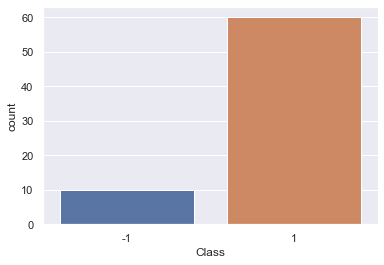

In [42]:
sns.set_theme()
target = df['Class']
sns.countplot(x=target); 
# il faut désormais toujours placer data=, x= ect... ici seul x= donne le bon graph, data=target donne 1 seul bloc de label Ox = 0

La taille du jeu de données étant conséquente, on ne va prendre qu'une partie des données.

- (d) Dans df_inliers stocker les données des inliers (de label 1).
- (e) Dans df_outliers stocker les données des outliers (de label -1).
- (f) Réduire la taille de df_inliers aux 20000 premières données.
- (g) Concaténer df_inliers et df_outliers dans un DataFrame df.
- (h) Afficher la proportion de chacun des labels dans le jeu de données après les avoir stockés dans target.

In [43]:
# (d)
df_inliers = df[df.Class==1]
# (e)
df_outliers = df[df.Class==-1]
# (f)
# df_inliers = df_inliers.iloc[:20000, :]  # je ne fais pas ici car que 60 lignes chargées
# (g)
df = pd.concat([df_inliers, df_outliers], axis = 0)
# (h)
target = df.Class
target.value_counts()

 1    60
-1    10
Name: Class, dtype: int64

C:\Users\UserPC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


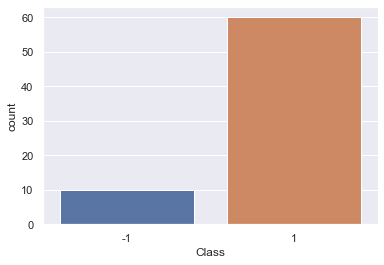

In [44]:
sns.countplot(target); # donne le meme graph car j'ai rien changé au final hors mis les créations de dataframe et target

(i) Stocker dans une variable frac la proportion d'outliers dans le jeu de données, et l'afficher.

In [45]:
# question pas claire pour moi, ils veulent qu'on stock la valeur du  %age d'outliers
frac = target[target==-1].value_counts()/target.value_counts().sum()
frac

-1    0.142857
Name: Class, dtype: float64

On remarque bien l'inégalité extrême de représentation des classes.
On va séparer notre jeu de données pour avoir un échantillon de test afin d'évaluer la performance des algorithmes.
La fonction train_test_split respecte la proportion des classes dans les 2 nouveaux jeux de données.

(j) Séparer le jeu de données en un échantillon d'apprentissage et de test. Ce dernier va représenter 20% des données.
   

In [46]:
"""
Les méthodes que l'on va utiliser sont des méthodes d'apprentissage non-supervisé, les labels de y_train ne seront pas utilisés dans les algorithmes.
"""

"\nLes méthodes que l'on va utiliser sont des méthodes d'apprentissage non-supervisé, les labels de y_train ne seront pas utilisés dans les algorithmes.\n"

In [47]:
X = df.drop('Class', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=5)

(k) Enlever la variable Time qui n'est pas pertinente pour la modélisation.

In [48]:
X_train = X_train.drop('Time', axis=1) # il faut enlever "time" des 2 set de X
X_test = X_test.drop('Time', axis=1)

## 2 - Isolation Forest()
### en supervisé sur classes -1 outliers (anomalies) ou +1 inliers
Isolation forest est une méthode basée sur les arbres de décision qui permet d’identifier les outliers.

L’idée est simple :

- On sélectionne une variable (feature) de façon aléatoire.
- Encore de façon aléatoire, on sépare les données selon cette variable en deux sous-ensembles de données.
- On répète les deux étapes précédentes jusqu’à ce qu’une donnée soit isolée.
- De manière récursive, on répète les étapes précédentes.

Pourquoi cela fonctionne ?

Les outliers ont tendant à être isolés en le moins de coupes possibles.  
- On a ainsi une structure d’arbre :  

l est intuitif de voir que les feuilles (points isolés) les plus proches de la racine ont plus de chance d’être des outliers.
Nous allons maintenant appliquer cet algorithme à notre jeu de données.

La méthode IsolationForest du module sklearn.ensemble permet d'instancier l'algorithme, il prend principalement en paramètres :

- n_estimators : Nombre d'estimateurs/arbres (il s'agit ici de créer une foret d'arbres afin d'avoir un résultat plus robuste).
- contamination : Hyperparamètre qui représente la proportion d'outliers, permet de limiter le nombre de données à considérer comme anomalie.  

(a) Instancier un objet IsolationForest dont on fixera la valeur de l'argument contamination à 3%. On prendra aussi n_estimators=100.

In [49]:
model_if = IsolationForest(n_estimators=100, contamination=0.03, n_jobs=-1)

(b) Entraîner le modèle et prédire les labels de l'échantillon de test.  
(c) Utiliser une matrice de confusion pour évaluer les performances de cet algorithme.

In [50]:
import sklearn
print('Sklearn               : ' + sklearn.__version__)

Sklearn               : 1.0.2


In [51]:
model_if.fit(X_train, y_train)
y_pred = model_if.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Réel'], colnames=['Predit'])

C:\Users\UserPC\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Predit,-1,1
Réel,,
-1,1,1
1,0,12


(d) Afficher le rapport de classification pour évaluer les performances de l'algorithme

In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.50      0.67         2
           1       0.92      1.00      0.96        12

    accuracy                           0.93        14
   macro avg       0.96      0.75      0.81        14
weighted avg       0.93      0.93      0.92        14



Pour une problématique complexe de détection de fraude, l'algorithme est déjà capable d'arriver à des scores corrects.

Le f1-score est une des métriques très utilisée pour juger de la performance d'un modèle quand il y a déséquilibre de classe.  
Cependant, on peut etre interessé par l'optimisation d'une métrique spécifique telle que le rappel.

Nous allons essayer d'améliorer le rappel en jouant sur le taux de contamination.

- (e) Créer une grille de paramètres qui prendra en arguments :
  - contamination : de 0.01 à 0.05 en 10 coupes.
n_estimators : de 100 à 300 en 5 coupes.
- (f) Instancier un cross-validateur de type StratifiedKFold avec n_splits = 3.
- (g) La fonction make_scorer permet d'instancier un scoreur qui suit une métrique de notre choix, utiliser resc = make_scorer(recall_score,pos_label = -1) afin de suivre la métrique de rappel.
- (h) Entraîner une instance de GridSearchCV en précisant les arguments estimator, param_grid, scoring et cv.
- (i) Retrouver le meilleur estimateur à l'aide de l'attribut best_estimator_, prédire les labels de l'échantillon de test puis afficher une matrice de confusion.

In [54]:
import time
start = time.time()

param_grid = {'contamination': np.linspace(0.01, 0.05, 10), 'n_estimators': [100, 150, 200, 250, 300]}  # mis n-estimators en liste d'entiers car linspace fait pareil mais en float => erreur

#  make_scorer permet d'instancier un scoreur qui suit une métrique de notre choix
resc = make_scorer(recall_score,pos_label = -1)  # a archiver et voir la doc

grid =GridSearchCV(IsolationForest(), param_grid, cv=3, scoring=resc)  # cv = statifiedKfold si entier donné et le scorer a améliorer est inclu ici dans la gridsearchcv !!!


X_train_array = X_train.to_numpy()   # transformer en array car isolation forest methode fit demande des array ( sans nom de colonnes ) et X_train ici est une serie avec nom de cols
y_train_array = y_train.to_numpy()

grid.fit(X_train_array, y_train_array)

print(grid.best_score_) 
print(grid.best_params_)   
model_if_best= grid.best_estimator_
 
# matrice de confusion
y_pred = model_if_best.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'])

end = time.time()
print("temps de calculs : ", end-start)

0.39999999999999997
{'contamination': 0.01888888888888889, 'n_estimators': 150}
temps de calculs :  158.03598308563232


C:\Users\UserPC\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


(j) Afficher le rapport de classification.

In [55]:
print(classification_report(y_test, y_pred))  # plante si y_pred n'a aucun -1 anomalie de détectée ( ma base est petite) => vérifer que y_test et y_pred ont au moin 1 anomalie  !!!

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           1       0.86      1.00      0.92        12

    accuracy                           0.86        14
   macro avg       0.43      0.50      0.46        14
weighted avg       0.73      0.86      0.79        14



C:\Users\UserPC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\UserPC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\UserPC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cette fois-ci, le modèle a un meilleur score de recall.

Finalement, l'algorithme d'isolation forest donne des résultats acceptables malgré la complexité de la problématique.

## 3 - OneClassSVM() 
Souvent, les tâches en machine learning quand il s’agit de détecter les outliers sont :

- Rarement supervisés : les données sont labelisées.  
- Parfois semi-supervisés : seules quelques données sont labelisées.  
- Souvent non supervisés : Pas de label.  

One class SVM est une version du modèle classique SVM qui permet de faire de la Novelty Detection.

La Novelty Detection, c’est détecter si une nouvelle observation est un outlier sachant l’hypothèse suivante :
- Les données d’entraînement ne sont pas polluées par des outliers.  

Cette hypothèse est primordiale puisqu’on va :
- Isoler les données d’entrainement en les séparant de l’origine grâce à un hyperplan.
- Prédire si une nouvelle observation est une novelty ou non (outlier ou non) selon quelle région elle se trouve (d’un côté ou l’autre de l’hyperplan).

Ainsi :

- Il n'y a pas besoin d'avoir des données labelisées pour entrainer le modèle.
- Cependant, il faut s'assurer que les données soient le moins polluées par des outliers.

On va d'abord garder seulement les données non polluées par les anomalies.

(a) Exécuter la cellule suivante pour stocker les variables explicatives des observations associées au label 1 dans une variable X_train_inliers.

In [56]:
# On sélectionne uniquement les labels qui correspondent à 1
y_inliers = y_train[y_train.values==1]

# On crée une liste d'index pour pouvoir récupérer les variables explicatives de ces index
liste = list(y_inliers.index.values)

# On récupère ces variables explicatives dans un nouveau DataFrame
X_train_inliers = X_train.loc[liste]

On cherche à séparer les données du point origine (de coordonnées 0).

Comme vu dans le module machine learning, il est préférable alors de normaliser les données.

- (b) Instancier un objet de type MinMaxScaler en précisant l'argument feature_range=(-1,1) afin que les données soient comprises entre -1 et 1.
- (c) L'entraîner sur X_train_inliers.
- (d) Transformer X_train_inliers et X_test à l'aide de ce scaler.

In [57]:
# (b)
scaler = MinMaxScaler(feature_range=(-1,1))
# (c)
scaler.fit(X_train_inliers)
# (d)
scaler.transform(X_train_inliers)
scaler.transform(X_test)

print() # pour éviter l'affichage de toutes les arrays transformés

(e) Instancier un objet de type OneClassSVM, les paramètres de ce modèle sont :
- nu :  νν  la proportion d'anomalies à considérer dans le jeu de données (équivalent à la contamination), on choisira la proportion d'outliers de notre échantillon.
- kernel : le type de noyau à utiliser, on choisira le noyau gaussien 'rbf'.
- gamma : détermine la forme de l'hyperplan séparateur. On testera plusieurs valeurs à travers une grille de recherchesi besoin ( non fait ici ).
(f) L'entraîner sur X_train_inliers.  

Dans le cas où on ne connait pas la proportion des outliers, on teste plusieurs paramètres en utilisant une grille de recherche.

In [58]:
from sklearn import svm

model_ocsvm = svm.OneClassSVM(nu=0.024009, kernel='rbf', gamma='scale')  # gamma = coef du noyau utilise 1 / (n_features * X.var()) si 'scale'
model_ocsvm.fit(X_train_inliers)

OneClassSVM(nu=0.024009)

- (g) Prédire les labels des observations de l'échantillon de test dans une variable y_pred.
- (h) Afficher les résultats sous la forme d'une matrice de confusion.

In [59]:
y_pred = model_ocsvm.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'])

Predicted,-1,1
True,,
-1,0,2
1,3,9


(i) Afficher le rapport de classification de la prédiction

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           1       0.82      0.75      0.78        12

    accuracy                           0.64        14
   macro avg       0.41      0.38      0.39        14
weighted avg       0.70      0.64      0.67        14



Il est possible d'optimiser ce modèle en testant plusieurs hyperparamètres à l'aide d'une grille de recherche.

Les résultats du modèle de base restent quand même très satisfaisants.

## 4 - Pour aller plus loin 
Même si les algorithmes traités sont simples et intuitifs, ils donnent des résultats assez efficaces sur une problématique complexe.

D'autres techniques existent pour traiter la détection d'anomalies telles que L'enveloppe elliptique et le Local Outlier Factor.

L'image suivante, qu'on retrouve dans la documentation de scikit-learn, donne une intuition sur les différences entre les algorithmes (points bleus sont les anomalies):

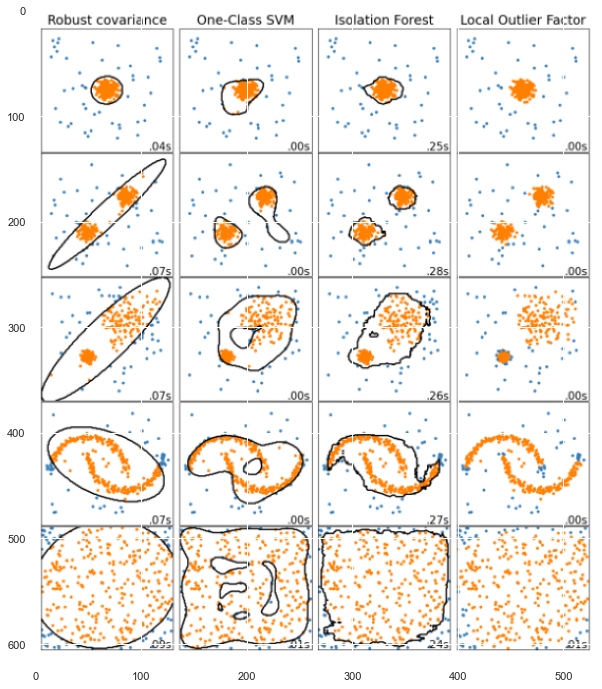

In [61]:
from matplotlib import image

img = image.imread('anomalies enveloppe elliptique ou local outlier factor.png')
plt.figure(figsize=(16, 12))
plt.imshow(img)

## Conclusion 
- La problématique de détection d'anomalie est considérée lorsque le jeu de données contient des labels spécifiques à de très faible proportions.
- Plusieurs algorithmes et techniques permettent d'aborder cette problématique.
- Les différents modèles peuvent facilement être implémentés et entraînés à l'aide de scikit-learn.
- Avoir à priori des données labélisées permet de valider l'efficacité d'un modèle.

# D - Classif semi-supervisée des NaN

Classification complexe avec scikit-learn

Classification semi-supervisée

Cet exercice est un cas réel d'utilisation de la classification semi-supervisée. Les packages utilisés seront numpy, pandas, scikit-learn ses 
sous-packages notamment : metrics, semi_supervised et model_selection.

Le jeu de données que nous allons étudier porte sur les paramètres pour classer des composés chimiques contre le SIDA.
La principale tâche est d'utiliser une classification semi-supervisée pour grouper les composés en deux clusters : actifs ou inactifs.

L'exercice est composé de plusieurs questions. Vous êtes invités à les faire dans l'ordre ainsi qu'à faire attention à respecter le nom des variables.

## 1 - Principe de fonctionnement 
L'apprentissage semi-supervisé est une classe de techniques d'apprentissage automatique qui utilise un ensemble de données étiquetées et non-étiquetées.
Il a été démontré que l'utilisation de données non-étiquetées, en combinaison avec des données étiquetées, permet d'améliorer significativement la qualité 
de l'apprentissage.
Un autre intérêt provient du fait que l'étiquetage de données nécessite l'intervention d'un utilisateur humain. Lorsque les jeux de données deviennent
 très grands, cette opération peut s'avérer fastidieuse voire impossible.
 
 Les hypothèses de base pour la plupart des algorithmes d'apprentissage semi-supervisés sont :
- Les instances proches ont probablement le même label de classe.
- Deux points qui sont connectés par un chemin traversant des régions à fortes densités doivent avoir le même label.  

Premièrement, l'algorithme de classification traditionnel est entraîné avec les données d'apprentissage labellisées.  
Par la suite, les données d'apprentissage sont classifiées mais non labellisées avec l'algorithme.
Les exemples prédits avec la meilleure confiance sont sélectionnés et considérés comme données d'apprentissage labellisées.
Le classifieur utilise donc ses propres prédictions pour apprendre lui-même.

In [62]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from scipy.sparse.csgraph import connected_components
import pandas as pd


df = pd.read_csv('hiva.csv', sep=';')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Class   30 non-null     float64
 1   V1      60 non-null     float64
 2   V10     60 non-null     float64
 3   V100    60 non-null     float64
 4   V1000   60 non-null     float64
 5   V1001   60 non-null     float64
 6   V1002   60 non-null     float64
 7   V1003   60 non-null     float64
 8   V1004   60 non-null     float64
 9   V1005   60 non-null     float64
 10  V990    60 non-null     float64
 11  V991    60 non-null     float64
 12  V992    60 non-null     float64
 13  V993    60 non-null     float64
 14  V994    60 non-null     float64
 15  V995    60 non-null     float64
 16  V996    60 non-null     float64
 17  V997    60 non-null     float64
 18  V998    60 non-null     float64
 19  V999    60 non-null     float64
dtypes: float64(20)
memory usage: 9.5 KB


## 2 - méthode séparat° y label, y non-label, split train et test avec y_train non label = -1

Dans le monde réel, les données contiennent des anomalies ou des valeurs manquantes qui compromettent la qualité du jeu de données.
Le dataset df contient 8000 instances et 1616 variables explicatives.

Quelques instances du dataset df ne sont pas labellisées. Autrement dit, l'étiquette de classe est manquante pour certaines observations.

(g) Calculer le nombre des instances non labellisées.

- Calcul nombre des instances non labellisées = les targets NaN   
  df['Class'].isnull().sum()

La moitié des observations sont non labellisées.  
Il est alors important d'entraîner un modèle en combinant les données avec labels et sans labels.

- (h) Affecter les données labellisées et non labellisées respectivement dans les variables : labeled_data et unlabeled_data.

In [63]:
# Séparation des données labellisées et non labellisées
labeled_data = df[(df['Class']==1) | (df['Class']==0)]
unlabeled_data = df[(df['Class']!=1) & (df['Class']!=0)]

Afin d'évaluer les performances du modèle de classification, il faut isoler une partie des données qui attesteront de la qualité du modèle une fois entraîné.

Pour cela il faut systématiquement diviser les données en un ensemble d'entraînement, train, et un ensemble de test test.

Usuellement, la taille de jeu de test est comprise entre 15% et 30% de la quantité totale de données disponibles. Le choix de la répartition  
dépend essentiellement de la quantité et de la qualité des données disponibles.  

Les données qui attesteront de la qualité du modèle (test) doivent être labellisées.

- (i) Diviser les matrices en un ensemble d'entraînement et un ensemble de test.

NB : Les échantillons seront aléatoirement répartis entre le jeu d'entraînement et le jeu de test, et la taille du jeu de test doit correspondre   
à 20 % de la quantité totale des données disponibles, soit 1600 observations pour tester le modèle de classification.

In [64]:
# Décomposition des données en deux ensembles d'entraînement et de test.
test = labeled_data.iloc[:6,:]              # 30 données avec cible labélisée x 20% = 6 ( vrai dataset 8000x0.2=1600) => ici 6 lignes donc
train = pd.concat([labeled_data.iloc[6:,:], unlabeled_data])  # => le reste des lignes soit 30-6 = 24 labelisées + 30 non labélisées = 54 lignes
# ici test et train sont 2 df avec target + features

Les données cibles sont stockées dans le premier attribut Class.  
Les variables explicatives ou les features de chaque composé chimique sont stockées dans les autres 1616 attributs du dataset df.

- (j) Créer deux variable X_train et y_train dans lesquelles vous stockez respectivement les features d'entraînement et les étiquettes de classe correspondantes.
- (k) Créer deux variable X_test et y_test dans lesquelles vous stockez respectivement les features de test et les étiquettes de classe correspondantes.

In [65]:
y_train = train.Class
X_train = train.drop('Class', axis = 1)  # attention c'est la colonne Class' à liminer ici et pas 'y_train' qui n'existe pas dans train

y_test = test.Class
X_test = test.drop('Class', axis = 1)  # attention c'est la colonne Class' à liminer ici et pas 'y_test' qui n'existe pas dans test

# leur solution + rapide
# X_test, y_test = test.iloc[:, 1:], test['Class']
# X_train, y_train = train.iloc[:, 1:], train['Class']

Pour pouvoir utiliser la classification semi-supervisée avec scikit-learn, les observations non labellisées doivent avoir -1 comme étiquette.

- (l) Étiqueter à -1 les observations non labellisées.
   
Rappel : la méthode fillna permet de remplacer les valeurs manquantes "NaN" par la valeur passée en paramètre.

In [66]:
# Etiquetage des observations non labellisées
y_train.fillna(-1, inplace=True)   # serie.fillna() marche aussi

## 3 - Algo de classif non supervisé LabelSpreading() LabelPropagation()

Scikit-learn propose **LabelSpreading** et **LabelPropagation** comme algorithmes de classification semi-supervisée.
Ils diffèrent par des modifications de la matrice de similarité et des poids de données labellisées.

- (a) Créer un Classificateur label_model, ayant pour paramètres : n_neighbors=7, kernel='knn', max_iter=10 et gamma=0.20, en utilisant la méthode LabelSpreading du package semi_supervised.
- (b) Entraîner l'algorithme sur l'ensemble d'entraînement (X_train et y_train).

In [67]:
label_model = LabelSpreading( n_neighbors=7, kernel='knn', max_iter=10, gamma=0.20)

label_model.fit(X_train, y_train)

LabelSpreading(gamma=0.2, kernel='knn', max_iter=10)

## 4 - Evaluation du modèle de classification 

Il est alors possible de calculer la prédiction pour les données présentes dans l'ensemble de test, et calculer la matrice de confusion.

- (a) Calculer la matrice de confusion.

In [68]:
y_pred = label_model.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite']) 

Classe prédite,0.0,1.0
Classe réelle,,
0.0,3,1
1.0,1,1


Il est souvent utile d'avoir un ratio pour décrire la performance du modèle de classification.
Le  κ  de Cohen est un coefficient destiné à mesurer l'accord entre deux variables qualitatives ayant les mêmes modalités.

Pour un modèle de classification binaire, ayant pour matrice de confusion :

VP, VN, FP, FN

Le coefficient  κ  se calcule comme suit :  κ =(Paccord−PHasard)/(1−PHasard)

    Paccord  représente la Proportion d'accords observée :  Paccord=(VN + VP)/(VN + FP + FN + VP)
    
   La Proportion théorique ou globale d'accords observés pourrait être estimée :  
       
 PHasard = P0 + P1 = (VN + FP)/(VN + FP + FN + VP) . (VN + FN)/(VN + FP + FN + VP) + (FN + VP)/(VN + FP + FN + VP) . (FP + VP)/(VN + FP + FN + VP)
 
 * la méthode du κ (kappa) mesure l’accord entre observateurs lors d'un codage qualitatif en catégories *
 
 
- (b) Calculer le coefficient de Cohen Kappa.

In [69]:
cohen_kappa_score(y_test, y_pred)  # => 0.85 = 85% pour vrai dataset
# from sklearn.metrics import cohen_kappa_score

0.25

# E - Classification avancée 

## 1 - Persistance de modèles

Un véritable projet de Machine Learning s'arrête rarement à l'entraînement et l'évaluation d'un modèle sur un jeu de données test.
Après avoir trouvé le bon modèle et l'avoir entraîné (parfois pendant plusieurs heures) il est indispensable d'avoir un moyen de le conserver pour une utilisation future, sans avoir à le réentraîner.

Le module pickle, intégré à Python, et son équivalent plus efficace avec scikit-learn, joblib, permettent d'enregistrer en local un modèle ou une Pipeline et de les charger plus tard dans n'importe quel code Python.

Ainsi, il est possible, par exemple, d'obtenir en un temps minime des prédictions de notre modèle à partir de nouvelles données.

- (a) Importer pandas en tant que pd.
- (b) Importer la classe RandomForestClassifier depuis sklearn.ensemble.
- (c) Importer pickle.
- (d) Lire le fichier 'wine.csv'.

In [70]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import pickle

df = pd.read_csv('wine.csv', sep=';')

La variable à prédire est la première colonne Alcohol.

- (e) Importer model_selection à partir de sklearn.
- (f) À partir du jeu de données, créer un ensemble d'entraînement et un ensemble de test.
- (g) Créer un classifieur de classe RandomForest et l'entraîner.

In [71]:
df.shape

(60, 13)

In [72]:
df.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Prolin
0,3,12.87,4.61,2.48,21.5,86,1.70,0.65,0.47,0.86,7.650000,0.54,1.86
1,1,13.28,1.64,2.84,15.5,110,2.60,2.68,0.34,1.36,4.600000,1.09,2.78
2,3,12.82,3.37,2.30,19.5,88,1.48,0.66,0.40,0.97,10.260000,0.72,1.75
3,3,12.77,2.39,2.28,19.5,86,1.39,0.51,0.48,0.64,9.899999,0.57,1.63
4,2,12.43,1.53,2.29,21.5,86,2.74,3.15,0.39,1.77,3.940000,0.69,2.84


In [73]:
from sklearn import model_selection

X = df.drop('Alcohol', axis=1)
y = df['Alcohol']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

Le **module pickle** contient deux fonctions : dump() et load() qui permettent respectivement d'enregistrer et de charger un modèle sous forme d'un fichier  
'.pkl' ou '.sav', mais l'argument file de ces deux fonctions doit être respectivement modifiable et lisible.  

On doit alors utiliser la fonction open.

Exemple :

filename = 'last_model.pkl'
#enregistre le modèle

pickle.dump(model, open(filename, 'wb'))
#charge le modèle

loaded_model = pickle.load(open(filename, 'rb'))

Il est également possible de sauvegarder un modèle sous forme de chaîne de caractères à l'intérieur d'une session Python avec pickle, grâce aux fonctions dumps() et loads().  

Mais l'utilité de ces fonctions est limitée :   
joblib est un package similaire à pickle, utilisant les mêmes fonctions dump() et load(), mais plus adapté aux modèles scikit-learn,     
car il sauvegarde les objets sous formes de tableaux numpy.  

Ainsi les modèles avec beaucoup de paramètres, ou qui stockent l'ensemble des données (comme les KNN) seront enregistrés plus facilement.

De plus, les fonctions s'utilisent de manière plus facile, et permettent de sauvegarder des fichiers '.joblib' ou '.pkl'

Exemple:

from joblib import dump, load

dump(model, 'saved_model.joblib')

my_model = load('saved_model.joblib')

- (h) Importer les fonctions dump et load de joblib.
- (i) Enregistrer le modèle crée plus haut dans un fichier 'md.joblib'.

- (j) Charger le modèle sous le nom 'loaded_model'.
- (k) Afficher les prédictions du modèle sur X_test.

In [74]:
from joblib import load, dump

dump(model, 'md.joblib')  # dump() enregistre le model sous le nom 'md.joblib' ( md pour model, jioblib = extension) sous mon dossier de travail

loaded_model = load('md.joblib') #  load() charge le fichier md.joblib dans la variable loaded_model

loaded_model.predict(X_test) # puis on utilise le model chargé par son instanciation loaded_model

loaded_model.score(X_test, y_test)

1.0

Pour les modèles ou jeux de données très volumineux, la fonction joblib.dump() possède un paramètre très utile : compress, qui permet de réduire la taille du fichier avec   
différents niveaux de compression (0 à 9).  

NB : Plus un fichier est compressé, plus il sera lent à écrire et lire.  

Le modèle 'md.joblib' est sauvegardé en local, et peut être utilisé n'importe quand dans le futur.

Cependant, il est important de prendre en considération le point suivant :  

Pensez à bien noter la version de Python, et des principaux packages utilisés lors de la création du modèle.  
Vous aurez certainement besoin des mêmes versions majeures installées lorsque vous chargerez votre modèle.